In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab

setup_google_colab.setup_week6()

TensorFlow 1.x selected.
shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-07-25 09:08:11--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-07-25 09:08:11 (44.7 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns

# Image Captioning Project


<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [2]:
import sys
sys.path.append("..")
import grading
import download_utils

In [3]:
download_utils.link_all_keras_resources()

In [4]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


In [5]:
# downloading data...
download_utils.link_week_6_resources()

# Extract image features

I used a pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extracted it's last hidden layer as an embedding:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/inceptionv3.png?raw=1" style="width:70%">

In [6]:
IMG_SIZE = 299

In [7]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

I have loaded the image features already extracted using an InceptionV3 as an encoder. Below is the code to do the following: 
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [8]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [9]:
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


# Extract captions for images

In [10]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


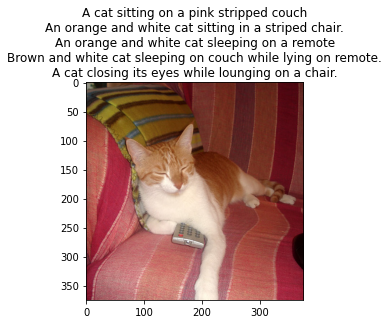

In [11]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [12]:
# captions data preview
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [13]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Returns {token: index} for all train tokens (words) that occur 5 times or more, 
    with 0 indexing.
    
    """
    v = defaultdict(int)
    for captions in train_captions:
        for caption in captions:
            for token in split_sentence(caption):
                v[token] += 1

    vocab = [token for token, count in v.items() if count >= 5]
    vocab.extend([PAD, UNK, START, END])
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    Converting tokens in captions to above defined indices
    'captions' argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    
    """
    unk_idx = vocab[UNK]
    res = []
    for caps in captions:
        res_for_image = []
        for cap in caps:
            cap_indices = list(map(lambda token: vocab.get(token, unk_idx),
                                   [START] + split_sentence(cap) + [END]))
            res_for_image.append(cap_indices)
        res.append(res_for_image)
    return res


In [14]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [15]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

PAD tokens are added to ensure that all sentences have equal length, they are ignored during processing.

In [16]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    This function puts vocabulary indexed captions into a numpy matrix of shape (len(batch_captions), columns),
    here "columns" is max(map(len, batch_captions)) when max_len is None
    and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.

    """
    if max_len is None:
        max_len = max(map(len, batch_captions))
    else:
        max_len = min(max_len, max(map(len, batch_captions)))
        
    matrix = np.zeros((len(batch_captions), max_len), dtype='int32') + pad_idx
    for row_idx, row in enumerate(batch_captions):
        row = row[:max_len]
        matrix[row_idx, :len(row)] = row
    return matrix

In [17]:
# make sure you use correct argument in caption_tokens_to_indices--------------------------------------------------------
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

## Defining Architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

In [18]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [19]:
s = reset_tf_session()
tf.set_random_seed(42)

In [20]:
class decoder:
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    
    sentences = tf.placeholder('int32', [None, None])
    
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")

    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))

    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    word_embeds = word_embed(sentences[:, :-1])
    
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))

    flat_ground_truth =tf.reshape(sentences[:, 1:], [-1])

    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)
    flat_loss_mask = tf.cast(flat_loss_mask, 'float32')

    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    loss = tf.reduce_sum(xent * flat_loss_mask) / tf.reduce_sum(flat_loss_mask)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

saver = tf.train.Saver()

s.run(tf.global_variables_initializer())

## Training Loop

In [22]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [23]:
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):

    random_images_idx = np.random.randint(0, len(images_embeddings), size=batch_size)
    batch_image_embeddings = images_embeddings[random_images_idx]
    
    batch_captions = list(map(choice, indexed_captions[random_images_idx]))
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [24]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100

Look at the training and validation loss, they should be decreasing!

In [25]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    
print("Finished!")

**************************************************
Training loss: 4.283454
Epoch: 0, train loss: 4.283453801631928, val loss: 3.6923160552978516
**************************************************
Training loss: 3.367569
Epoch: 1, train loss: 3.3675689418315886, val loss: 3.1667852139472963
**************************************************
Training loss: 3.010822
Epoch: 2, train loss: 3.010822184562683, val loss: 2.945984363555908
**************************************************
Training loss: 2.854194
Epoch: 3, train loss: 2.8541941730976106, val loss: 2.8841328763961793
**************************************************
Training loss: 2.759664
Epoch: 4, train loss: 2.7596639828681946, val loss: 2.7691098475456237
**************************************************
Training loss: 2.687222
Epoch: 5, train loss: 2.687221925020218, val loss: 2.7363933420181272
**************************************************
Training loss: 2.643566
Epoch: 6, train loss: 2.6435662980079653, val loss: 2

In [26]:
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.508044
Accuracy: 0.488
Example 0
Predicted: a dog is sitting at at the camera bench #END# #UNK# the the camera #END# the street #END# #END# #END# #END# #END#
Truth: the chihuahua is looking up at the wooden structure rather than at the moose on the ground #END# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a in in of kitchen kitchen kitchen with a kitchen #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: woman standing inside a large disorganized room in a kitchen #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a assortment of donuts are displayed a bakery case #END# #END# #END# #END# #END# #END# and and and and and and and
Truth: an assortment of donuts are in a display case #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [27]:
class final_model:
    
    encoder, preprocess_for_model = get_cnn_encoder()

    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    img_embeds = encoder(input_images)

    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    current_word = tf.placeholder('int32', [1], name='current_input')

    word_embed = decoder.word_embed(current_word)

    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    new_probs = tf.nn.softmax(new_logits)

    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

In [28]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
   
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
  
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player is swinging a bat at a ball


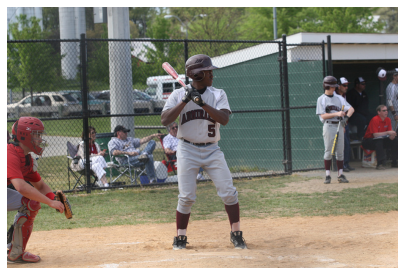

In [29]:
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]),)
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

#That's it! 

************************************************************************
************************************************************************

### **The images shown below are the examples where our model works fine.**
Despite the limited data available, our model has generalised well. Note that the images are both from the validation set and internet.


In [30]:
g_ex_ids=[369,196,300,301,391]
b_ex_ids=[163,41,230,193,360]

#g_imgs=[str(_)+'.jpg' for _ in [3,14,18,21,25]]
#b_imgs=[str(_)+'.jpg' for _ in [1,4,5,7,8]]

a man standing in a room with a remote control


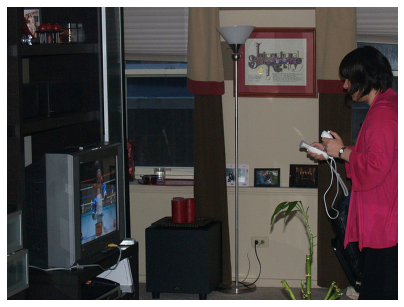

a woman sitting at a table with a cake


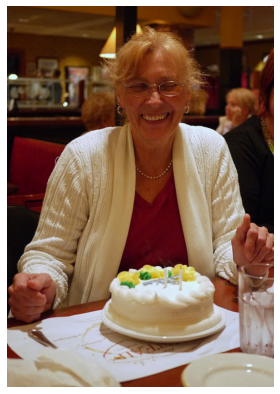

a group of zebras are standing in a field


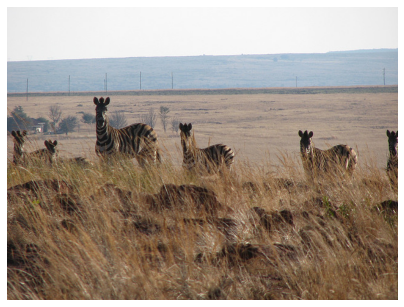

a man riding a skateboard down a street


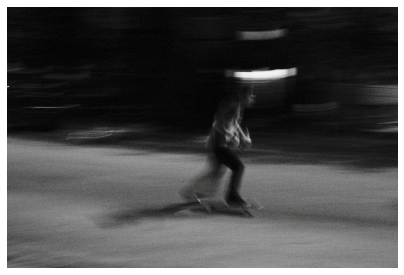

a pizza sitting on top of a stove top oven


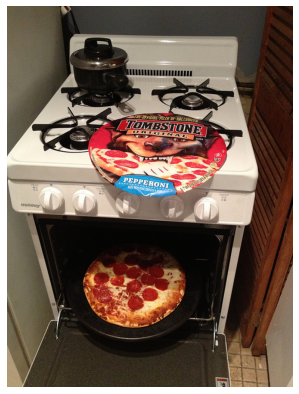

In [32]:
def get_g_ex(ids):
  for item in ids:
    show_valid_example(val_img_fns, item)
    time.sleep(1)

get_g_ex(g_ex_ids)    

## **The images shown below are the examples where our model fails.**

These images depict that our model fails to predict captions for images containing extra-specific features. Note that the images are both from the validation set and internet.

a woman is eating a doughnut with a glass of wine


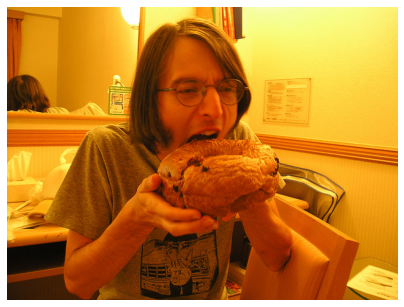

a man wearing a suit and tie and a tie


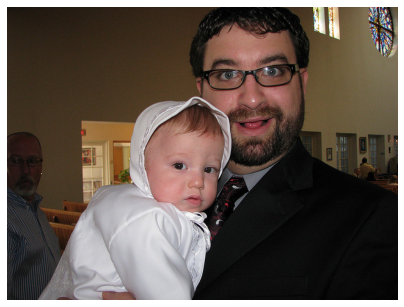

a man walking down a sidewalk with a bicycle


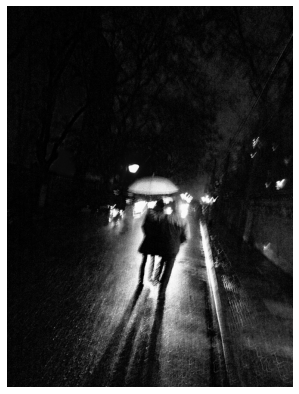

a young boy holding a tennis racket in a tennis court


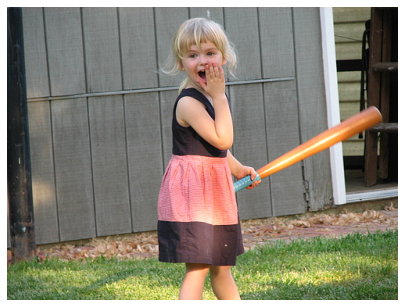

a man and a woman are riding on a boat


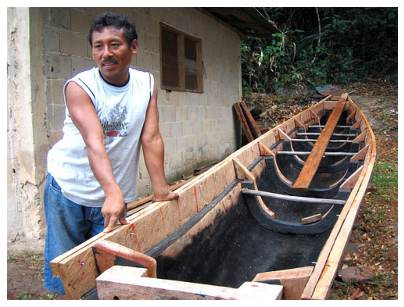

In [33]:
def get_b_ex(ids):
  for item in ids:
    show_valid_example(val_img_fns, item)
    time.sleep(1)
  
get_g_ex(b_ex_ids)  